# Proje√ß√£o de mapas

Sistema de refer√™ncia de coordenadas (CRS) s√£o importantes, porque as geometrias utilizadas em GeoDataFrame s√£o simplesmente uma cole√ß√£o de coordenadas em um espa√ßo arbitr√°rio. O CRS diz ao python como essas coordenadas est√£o relacionadas com o espa√ßo no planeta terra. Uma proje√ß√£o de mapa √© uma transforma√ß√£o sistematica de latitudes e longitudes em uma superficie plana, em que as unidades s√£o comumente representadas em metros (em vez de graus). Esta transforma√ß√£o s√£o usadas para representar a terra tridimensional em um mapa plano e bidimensional.

Como o CRS em diferentes conjuntos de dados espaciais diferem com bastante frequ√™ncia (isto √©, pode-se ter coordenadas definidas em graus decimais enquanto em outro conjunto de dados est√° em metros), √© um procedimento comum redefinir (ou reprojetar) o CRS para ser id√™ntico em ambos os datasets. √â importante que as camadas possuam o mesmo sistema de refer√™ncia de coordenadas, pois permite analisar as rela√ß√µes espaciais entre elas, como conduzir uma consulta de um Point em um Polygon.

Escolher uma proje√ß√£o apropriada para o seu mapa nem sempre √©  uma tarefa simples, porque depende do que voc√™ realmente quer representar com seu mapa e de qual √© a escala espacial dos seus dados. De fato, n√£o existe uma "proje√ß√£o perfeita", j√° que cada uma tem alguns pontos fortes e fracos, e voc√™ deve escolher uma proje√ß√£o que se ajuste melhor √†s suas necessidades. Na verdade, a proje√ß√£o que voc√™ escolher pode at√© dizer algo sobre voc√™:
    
![](images/Map-projections.png)
*Fonte: XKCD, See a full comic about ["What your favorite map projection tells about you"](https://xkcd.com/977/)*.

Para aqueles de voc√™s que querem um pouco mais de abordagem anal√≠tica para escolher a proje√ß√£o, voc√™ pode obter uma boa vis√£o geral em [georeference.org](http://www.georeference.org/doc/guide_to_selecting_map_projections.htm),  ou deste blog post introduzindo [os pontos fortes e fracos de algumas proje√ß√µes comumente usadas](http://usersguidetotheuniverse.com/index.php/2011/03/03/whats-the-best-map-projection/).

## Sistema de refer√™ncia de coordenadas (CRS) in Geopandas

Felizmente, para definir e alterar proje√ß√µes no Geopandas √© f√°cil. Neste tutorial vamos ver como recuperar as informa√ß√µes do sistema de refer√™ncia dos dados e como alter√°-lo. Tamb√©m vamos reprojetar um arquivo de dados de
WGS84 (coordenadas de latitude longitude) em uma proje√ß√£o de Lambert Azimuthal Equal Area que √© a [proje√ß√£o recomendada para o continente europeu](http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf) pela comiss√£o europeia.

Para este tutorial, usaremos o Shapefile chamado `Europe_borders.shp`  que possui as fronteiras dos pa√≠ses na Europa, o mesmo  conjunto de dados utilizados no geopandas-basics.ipynb.

O Shapefile deve sempre conter informa√ß√µes sobre o sistema de refer√™ncia de coordenadas que √© armazenado no arquivo `.prj` (pelo menos se os dados tiverem sido produzidos apropriadamente). Ao ler os dados em `GeoDataFrame` com Geopandas esta informa√ß√£o √© automaticamente armazenada no atributo `.crs` do GeoDataFrame.

- Vamos come√ßar lendo os dados do arquivo `Europe_borders.shp` e verificando o` crs`:

In [3]:
# Import necessary packages
import geopandas as gpd

# Read the file
fp = "data/Europe_borders.shp"
data = gpd.read_file(fp)

# Check the coordinate reference system
data.crs

{'init': 'epsg:4326'}

Como podemos ver, o `crs` √© um dicion√°rio Python com uma chave` init` que tem um valor `epsg: 4326`. Essa √© uma maneira muito t√≠pica de como o CRS √© armazenado em GeoDataFrames. H√° tamb√©m outra maneira t√≠pica de representar o sistema de refer√™ncia de coordenadas, ou seja, armazenar essa informa√ß√£o no formato [Proj4-string] (https://proj4.org/usage/quickstart.html).

O n√∫mero da sigla EPSG (* "European Petroleum Survey Group" *) √© um c√≥digo que informa sobre o sistema de coordenadas do conjunto de dados. "[Conjunto de dados de par√¢metros geod√©sicos EPSG] (http://www.epsg.org/) √© uma cole√ß√£o de defini√ß√µes de sistemas de refer√™ncia de coordenadas e coordena transforma√ß√µes que podem ser globais, regionais, nacionais ou locais em aplica√ß√µes". O c√≥digo EPSG `4326` que temos aqui, pertence ao sistema de coordenadas WGS84 (isto √©, as coordenadas est√£o em graus decimais: latitudes e longitudes).

Voc√™ pode encontrar muitas informa√ß√µes e listas de sistemas de refer√™ncia de coordenadas dispon√≠veis a partir de:

  - [www.spatialreference.org](http://spatialreference.org/)
  - [www.proj4.org](https://proj4.org/operations/projections/)
  - [www.mapref.org](http://mapref.org/CollectionofCRSinEurope.html)

- Vamos continuar verificando os valores na coluna `geometry` para verificar se o CRS de nosso GeoDataFrame parece correto:

In [2]:
data['geometry'].head()

0    POLYGON ((8.457777976989746 54.56236267089844,...
1    POLYGON ((8.71992015838623 47.69664382934571, ...
2    POLYGON ((6.733166694641113 53.5740852355957, ...
3    POLYGON ((6.858222007751465 53.59411239624024,...
4    POLYGON ((6.89894437789917 53.6256103515625, 6...
Name: geometry, dtype: object

Como podemos observar, os valores de coordenadas dos pol√≠gonos realmente se parecem com valores de latitude e longitude, ent√£o tudo parece estar em ordem.

A proje√ß√£o do WGS84 n√£o √© realmente boa para representar as fronteiras europ√©ias, ent√£o vamos converter essas geometrias na proje√ß√£o de Lambert Azimuthal Equal Area ([EPSG: 3035] (http://spatialreference.org/ref/epsg/etrs89-etrs-laea/) ), que √© a proje√ß√£o recomendada pela Comiss√£o Europeia.

Mudar a proje√ß√£o √© simples de se fazer com Geopandas (http://geopandas.org/projections.html#re-projecting) utilizando a fun√ß√£o `.to_crs ()`, que √© uma fun√ß√£o interna do GeoDataFrame. A fun√ß√£o tem dois par√¢metros alternativos: 1) `crs` e 2) `epgs`, que podem ser usados para fazer a transforma√ß√£o de coordenadas e reprojetar os dados no CRS que voc√™ deseja usar.

- Vamos reprojetar nossos dados para o `EPSG 3035` usando o par√¢metro `epsg`:

In [4]:
# Let's make a copy of our data
orig = data.copy()

# Reproject the data
data = data.to_crs(epsg=3035)

# Check the new geometry values
print(data['geometry'].head())

0    POLYGON ((4221214.558088431 3496203.404338956,...
1    POLYGON ((4224860.478308966 2732279.319617757,...
2    POLYGON ((4104652.175545862 3390034.953002084,...
3    POLYGON ((4113025.664284974 3391895.755505159,...
4    POLYGON ((4115871.227627173 3395282.099288368,...
Name: geometry, dtype: object


Podemos ver que os valores de coordenadas nas geometrias foram alterados! Agora, mudamos com sucesso a proje√ß√£o de nossa camada para uma nova.

Para realmente entender o que est√° acontecendo, √© bom explorar nossos dados visualmente. Portanto, vamos comparar os conjuntos de dados fazendo criando mapas.


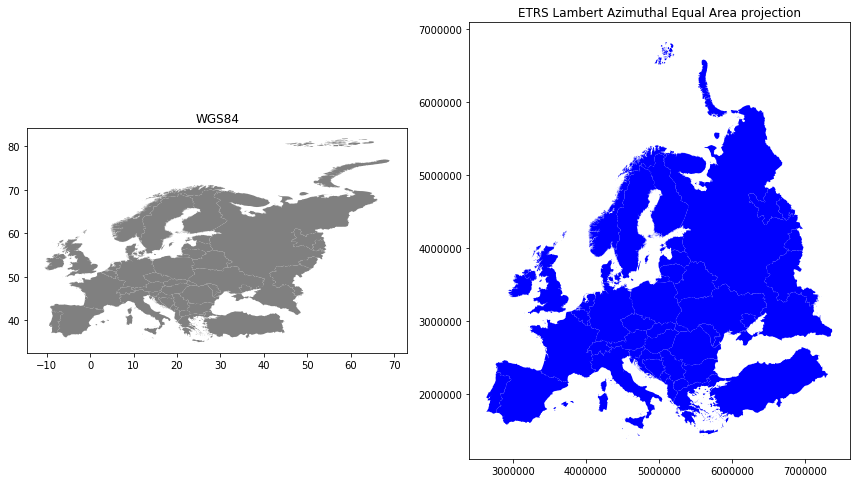

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# Plot the data in WGS84 CRS
orig.plot(ax=ax1, facecolor='gray');

# Add title
ax1.set_title("WGS84");

# Plot the one with ETRS-LAEA projection
data.plot(ax=ax2, facecolor='blue');

# Add title
ax2.set_title("ETRS Lambert Azimuthal Equal Area projection");

# Remove empty white space around the plot
plt.tight_layout()

Os mapas parecem bem diferentes, e o mapa reprojetado parece muito melhor na Europa, j√° que algumas √°reas, especialmente no norte, s√£o mais realistas e n√£o t√£o esticadas quanto no WGS84.

- Vamos salvar nossa camada projetada em um Shapefile para podermos us√°-lo mais tarde.

In [6]:
# Ouput filepath
outfp = "data/Europe_borders_epsg3035.shp"
    
# Save to disk
data.to_file(outfp)

## Calculando dist√¢ncias

Em seguida, conduziremos um exemplo pr√°tico com o arquivo `Europe_borders.shp`. Nosso objetivo √© encontrar as dist√¢ncias euclidianas dos centr√≥ides (pontos m√©dios) de todos os pa√≠ses europeus para a cidade de Helsinque, na Finl√¢ndia. Vamos calcular a dist√¢ncia entre Helsinki e outros pa√≠ses europeus usando uma proje√ß√£o m√©trica ([Azimuthal Equidistant -projection] (https://proj4.org/operations/projections/aeqd.html)) que nos d√° a dist√¢ncia em metros. Observe que essa proje√ß√£o √© um pouco menos utilizada.

- Vamos primeiro criar um GeoDataFrame que contenha um √∫nico ponto representando a localiza√ß√£o de Helsinki, na Finl√¢ndia:

Para instalar o m√≥dulo pycrs, voc√™ pode utilizar o seguinte comando: conda install -c conda-forge pycrs 

In [10]:
# Import necessary modules
from shapely.geometry import Point
import pycrs

# Create the point representing Helsinki (in WGS84)
hki_lon = 24.9417
hki_lat = 60.1666

# Create GeoDataFrame
helsinki = gpd.GeoDataFrame([[Point(hki_lon, hki_lat)]], 
                            geometry='geometry', 
                            crs={'init': 'epsg:4326'}, 
                            columns=['geometry'])

# Print 
print(helsinki)

                  geometry
0  POINT (24.9417 60.1666)


Como podemos ver, √© poss√≠vel criar um GeoDataFrame diretamente utilizando penas uma linha de c√≥digo. Observe que, aqui, especificamos o CRS diretamente passando o crs como um dicion√°rio Python `{'init': 'epsg: 4326'}` que √© uma maneira alternativa de definir o CRS. N√≥s tamb√©m dissemos que a informa√ß√£o `geometry` √© armazenada na coluna `geometry` que n√≥s definimos com o par√¢metro `columns = ['geometry'] `.

Em seguida, precisamos converter essa proje√ß√£o do `GeoDataFrame` para "Azimuthal Equidistant" que possui propriedades bastantes √∫teis, porque todos os pontos nessa proje√ß√£o est√£o em dist√¢ncias proporcionalmente corretas do ponto central (definidos com os par√¢metros `lat_0` e `lon_0`), e todos os pontos no mapa est√£o na dire√ß√£o correta em rela√ß√£o ao ponto central.

Para realizar a transforma√ß√£o, vamos utilizar novamente uma string Proj4 que podemos obter usando outra biblioteca concentrada para sistemas de refer√™ncia de coordenadas, chamada [pyproj] (https://github.com/jswhit/pyproj). Este pacote √© √∫til quando se trata de proje√ß√µes "especiais", como a demonstrada aqui.

¬†- Vamos criar nossa string Proj4 passando par√¢metros espec√≠ficos para o objeto `Proj ()` que s√£o necess√°rios para construir a [proje√ß√£o equidistante azimutal] (https://proj4.org/operations/projections/aeqd.html):
¬†¬†¬†¬†
¬†¬†¬†¬†- `proj = 'aeqd'` refere-se ao *especificador de proje√ß√£o* que determinamos ser Azimutal Equidistante ('aeqd ')
¬†¬†¬†¬†- `ellps = 'WGS84'` refere-se ao [elips√≥ide de refer√™ncia] (https://en.wikipedia.org/wiki/Reference_ellipsoid) que √© uma superf√≠cie matematicamente modelada (baseada em medi√ß√µes) que se aproxima da verdadeira forma do mundo. O World Geodetic System (WGS) foi estabelecido em 1984, da√≠ o nome.
¬†¬†¬†¬†- `datum = 'WGS84'` refere-se ao [Geodetic datum] (https://en.wikipedia.org/wiki/Geodetic_datum) que √© um sistema de coordenadas constitu√≠do com um conjunto de pontos de refer√™ncia que podem ser usados ‚Äã‚Äãpara localizar locais em Terra.
¬†¬†¬†¬†- `lat_0` √© a coordenada de latitude do ponto central na proje√ß√£o
¬†¬†¬†¬†- `lon_0` √© a coordenada de longitude do ponto central na proje√ß√£o

In [13]:
# Import pyproj
import pyproj

# Define the projection using the coordinates of our Helsinki point (hki_lat, hki_lon) as the center point
# The .srs here returns the Proj4-string presentation of the projection
aeqd = pyproj.Proj(proj='aeqd', ellps='WGS84', datum='WGS84', lat_0=hki_lat, lon_0=hki_lon).srs

# Reproject to aeqd projection using Proj4-string
helsinki = helsinki.to_crs(crs=aeqd)

# Print the data
print(helsinki)

# Print the crs
print('\nCRS:\n', helsinki.crs)

      geometry
0  POINT (0 0)

CRS:
 +units=m +proj=aeqd +ellps=WGS84 +datum=WGS84 +lat_0=60.1666 +lon_0=24.9417 


Como podemos ver, √© poss√≠vel criar um GeoDataFrame diretamente. Como podemos ver, a proje√ß√£o √© realmente centralizada em Helsinki, j√° que a posi√ß√£o 0 (em metros) de x e y √© definida agora diretamente no local onde definimos Helsinki para ser localizado (voc√™ entender√° melhor ao ver o mapa).

Em seguida, queremos transformar os dados `Europe_borders.shp` na proje√ß√£o desejada.

- Vamos criar uma nova c√≥pia do nosso GeoDataFrame em uma vari√°vel chamada `europe_borders_aeqd`:

In [14]:
# Create a copy
europe_borders_aeqd = data.copy()

- Vamos agora reprojetar nossos dados de fronteiras Europ√©ias na proje√ß√£o Azimutal Equidistante que foi centrada em Helsinque:

In [16]:
# Reproject to aeqd projection that we defined earlier
europe_borders_aeqd = europe_borders_aeqd.to_crs(crs=aeqd)

# Print 
print(europe_borders_aeqd.head(2))

            TZID                                           geometry
0  Europe/Berlin  POLYGON ((-1057542.597130521 -493724.801682817...
1  Europe/Berlin  POLYGON ((-1216418.435359255 -1243831.63520633...


Agora podemos ver que as coordenadas na coluna `geometry` s√£o n√∫meros bastante grandes, pois representam a dist√¢ncia em metros de Helsinki para diferentes dire√ß√µes, diferente ds medidas de graus utilizadas anteriormente.

- Vamos tra√ßar as fronteiras da Europa e a localiza√ß√£o de Helsinque para entender melhor como nossa proje√ß√£o se desenvolveu:

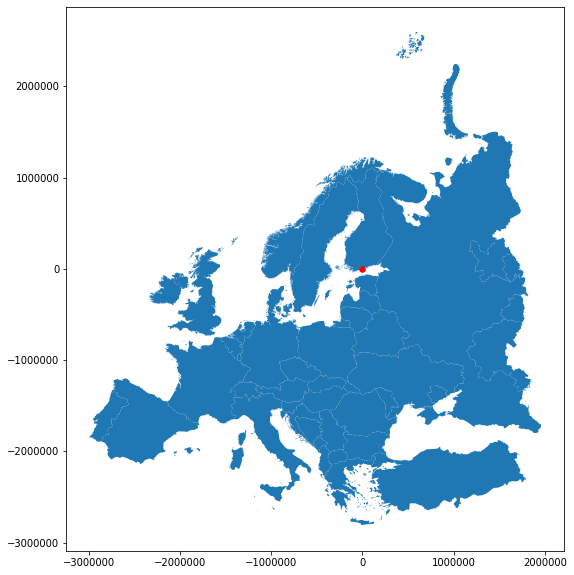

In [19]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

# Plot the country borders
europe_borders_aeqd.plot(ax=ax)

# Plot the Helsinki point on top of the borders using the same axis
helsinki.plot(ax=ax, color='red', markersize=30)

Como podemos ver no mapa, a proje√ß√£o √© de fato centralizada em Helsinque, pois a posi√ß√£o 0 dos eixos x e y est√£o localizadas onde Helsinque est√° posicionada. Agora os valores das coordenadas mostram a dist√¢ncia de Helsinque (ponto vermelho) para diferentes dire√ß√µes (Sul, Norte, Leste e Oeste) em metros.

Em seguida, nosso objetivo √© calcular a dist√¢ncia de todos os pa√≠ses at√© a cidade de Helsinque. Para podermos fazer isso, precisamos calcular os centr√≥ides de todos os pol√≠gonos que representam os limites dos pa√≠ses europeus.

- Isso pode ser feito facilmente em Geopandas usando o atributo `centroid`:

In [20]:
europe_borders_aeqd['centroid'] = europe_borders_aeqd.centroid
print(europe_borders_aeqd.head(2))

            TZID                                           geometry  \
0  Europe/Berlin  POLYGON ((-1057542.597130521 -493724.801682817...   
1  Europe/Berlin  POLYGON ((-1216418.435359255 -1243831.63520633...   

                                        centroid  
0  POINT (-1057718.135423443 -492420.5658204998)  
1  POINT (-1218235.216971496 -1242668.589667922)  


Agora n√≥s criamos uma nova coluna chamada `centroid` que possui as geometrias de Ponto representando os centr√≥ides de cada pol√≠gono (na proje√ß√£o Equidistante Azimutal).

Em seguida, calcularemos as dist√¢ncias entre os centr√≥ides dos pa√≠ses at√© Helsinque. Para fazer isso, poder√≠amos usar a fun√ß√£o `iterrows ()` que usamos anteriormente, mas aqui demonstraremos uma t√©cnica mais eficiente (mais r√°pida) para percorrer todas as linhas no (Geo) DataFrame usando a fun√ß√£o `apply ()`.

A fun√ß√£o [apply ()] (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) pode dar um grande impulso no desempenho sobre o `iterrows ()` e √© a maneira recomend√°vel de iterar as linhas em (Geo) DataFrames. Aqui, veremos como us√°-la para calcular a dist√¢ncia entre os centr√≥ides at√© Helsinque.

  - Primeiro, criaremos uma fun√ß√£o dedicada para calcular as dist√¢ncias chamadas de `calculate_distance()`:

In [21]:
def calculate_distance(row, dest_geom, src_col='geometry', target_col='distance'):
    """
    Calculates the distance between Point geometries.

    Parameters
    ----------
    dest_geom : shapely.Point
       A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
       A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    target_col : str
       A name of the target column where the result will be stored.

    Returns
    -------
    
    Distance in kilometers that will be stored in 'target_col'.
    """
    
    # Calculate the distances
    dist = row[src_col].distance(dest_geom)

    # Convert into kilometers
    dist_km = dist / 1000

    # Assign the distance to the original data
    row[target_col] = dist_km
    return row

Aqui, o par√¢metro `row` √© usado para passar os dados de cada linha do nosso GeoDataFrame para a fun√ß√£o. Outros paramaters s√£o usados para passar outras informa√ß√µes necess√°rias para usar a nossa fun√ß√£o.

- Antes de usar nossa fun√ß√£o e calcular as dist√¢ncias entre Helsinki e os centr√≥ides, precisamos obter a geometria do ponto Shapely do ponto central de Helsinque reprojetado, para que passamos passar para a nossa fun√ß√£o (no par√¢metro `dest_geom`. Podemos usar a fun√ß√£o `loc` para recuperar o valores especificos de √≠ndice e coluna:

In [22]:
# Retrieve the geometry from Helsinki GeoDataFrame
helsinki_geom = helsinki.loc[0, 'geometry']
print(helsinki_geom)

POINT (0 0)


Agora estamos prontos para usar nossa fun√ß√£o `apply ()`. Ao usar a fun√ß√£o, √© importante especificar a dire√ß√£o da itera√ß√£o que deve estar no nosso caso especificada com `axis = 1`. Isso garante que os c√°lculos sejam feitos linha por linha (em vez de coluna a coluna).
¬†¬†
- Quando iterar sobre um DataFrame ou GeoDataFrame, a fun√ß√£o apply √© usada seguindo o formato `GeoDataFrame.apply (name_of_your_function, param1, param2, param3, axis = 1)`
¬†¬†
¬†¬†¬†¬† - Observe que o primeiro par√¢metro √© sempre o nome da fun√ß√£o que voc√™ deseja usar ** SEM ** os par√™nteses. Isto ir√° iniciar a itera√ß√£o usando a fun√ß√£o que voc√™ criou, e os valores da linha ser√£o inseridos nos par√¢metros / atributos ao `row` dentro da fun√ß√£o (veja acima).

In [23]:
# Calculate the distances using our custom function called 'calculate_distance'
europe_borders_aeqd = europe_borders_aeqd.apply(calculate_distance, dest_geom=helsinki_geom, src_col='centroid', target_col='dist_to_Hki', axis=1)
print(europe_borders_aeqd.head(10))

            TZID                                           geometry  \
0  Europe/Berlin  POLYGON ((-1057542.597130521 -493724.801682817...   
1  Europe/Berlin  POLYGON ((-1216418.435359255 -1243831.63520633...   
2  Europe/Berlin  POLYGON ((-1194521.638643211 -571726.459328880...   
3  Europe/Berlin  POLYGON ((-1185933.276237431 -571780.052772927...   
4  Europe/Berlin  POLYGON ((-1182416.219837206 -569097.571220090...   
5  Europe/Berlin  POLYGON ((-1172799.400650827 -565749.438722841...   
6  Europe/Berlin  POLYGON ((-1162805.427517967 -563558.434197177...   
7  Europe/Berlin  POLYGON ((-1129053.540904054 -568388.469960322...   
8  Europe/Berlin  POLYGON ((-1109126.532709598 -570899.989413469...   
9  Europe/Berlin  POLYGON ((-703490.1465879157 -664009.791857452...   

                                        centroid  dist_to_Hki  
0  POINT (-1057718.135423443 -492420.5658204998)  1166.724332  
1  POINT (-1218235.216971496 -1242668.589667922)  1740.207536  
2  POINT (-1194210.7892994

√ìtimo! Agora calculamos com sucesso as dist√¢ncias entre os centr√≥ides de cada pa√≠s em formato de Polygon para a cidade de Helsinki em formato de Point. üòé

- Vamos verificar qual √© a dist√¢ncia mais longa e a dist√¢ncia m√©dia para Helsinque, em rela√ß√£o aos centr√≥ides de outros pa√≠ses europeus:

In [24]:
# Calculat the maximum and average distance
max_dist = europe_borders_aeqd['dist_to_Hki'].max()
mean_dist = europe_borders_aeqd['dist_to_Hki'].mean()

print("Maximum distance to Helsinki is %.0f km, and the mean distance is %.0f km." % (max_dist, mean_dist))

Maximum distance to Helsinki is 3470 km, and the mean distance is 1177 km.


Como podemos ver, os finlandeses que vivem no norte est√£o razoavelmente distantes de todos os outros pa√≠ses europeus, j√° que a dist√¢ncia m√©dia para outros pa√≠ses √© de 1185 quil√¥metros.

Aviso: Se voc√™ quiser calcular dist√¢ncias entre v√°rios locais ao redor do mundo, √© recomend√°vel usar a [f√≥rmula de Haversine] (https://en.wikipedia.org/wiki/Haversine_formula) para fazer os c√°lculos. o pacote [Haversine] (https://github.com/mapado/haversine) em Python fornece uma fun√ß√£o f√°cil de usar para calcular com base em valores de latitude e longitude.

## Resumo 

Durante este tutorial, vimos como:

**1)** definir o sistema de refer√™ncia de coordenadas com algumas abordagens diferentes, principalmente por:

¬†- especificando o sistema de refer√™ncia de coordenadas com o dicion√°rio crs, e. `{'init': 'epsg: 4326'}`
¬†- especificando CRS com Proj4-string usando a biblioteca PyCRS: `pycrs.parser.from_epsg_code (4326) .to_proj4 ()`
¬†- especificando CRS um pouco mais incomum (equidistante azimutal) com string Proj4 usando a biblioteca pyproj: `pyproj.Proj (proj = 'aeqd', ellps = 'WGS84', datum = 'WGS84', lat_0 = hki_lat, lon_0 = hki_lon). srs`

**2)** reprojetar (transformar) as geometrias de crs para outra usando a fun√ß√£o `to_crs ()` em GeoPandas

**3)** calcule as dist√¢ncias entre os locais e usar a fun√ß√£o `apply()` para iterar as linhas de maneira mais eficiente do que usando o `iterrows()`.